In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import models

def preprocess_image(path, target_size=96):
    import cv2
    import numpy as np

    # Đọc ảnh ở dạng grayscale
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    # Bước 1: Resize về 256x256
    img_256 = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)

    # Bước 2: Tiếp tục resize về kích thước mong muốn (target_size x target_size)
    resized = cv2.resize(img_256, (target_size, target_size), interpolation=cv2.INTER_AREA)

    # Chuẩn hóa pixel về [0, 1]
    normalized = resized.astype('float32') / 255.0

    # Thêm channel dimension: (target_size, target_size, 1)
    normalized = normalized.reshape(target_size, target_size, 1)

    # Thêm batch dimension: (1, target_size, target_size, 1)
    return np.expand_dims(normalized, axis=0)


In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, target_size=96):
        self.data = []
        for path, label in zip(image_paths, labels):
            img = preprocess_image(path, target_size)
            if img is not None:
                self.data.append((img, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        img_tensor = torch.tensor(img, dtype=torch.float32).permute(0, 3, 1, 2).squeeze(0)
        return img_tensor, label


In [3]:
def load_image_paths_and_labels(root_dir):
    import os
    image_paths, labels = [], []
    for label in os.listdir(root_dir):
        label_path = os.path.join(root_dir, label)
        if not os.path.isdir(label_path):
            continue
        for filename in os.listdir(label_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(label_path, filename))
                labels.append(int(label))
    return image_paths, labels


In [4]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Train loss: {total_loss / len(loader):.4f}")

def test(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    print(f"Test loss: {total_loss / len(loader):.4f} - Accuracy: {acc:.2f}%")


In [5]:
def predict_digits_from_folder(model, input_folder, output_csv, device='cpu', target_size=96):
    import os
    import pandas as pd

    model.eval()
    results = []
    for filename in sorted(os.listdir(input_folder)):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        path = os.path.join(input_folder, filename)
        img = preprocess_image(path, target_size)
        if img is None:
            print(f"⚠️ Bỏ qua ảnh lỗi: {filename}")
            continue
        img_tensor = torch.tensor(img, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
        with torch.no_grad():
            output = model(img_tensor)
            pred = output.argmax(dim=1).item()
        results.append([filename, pred])
    pd.DataFrame(results, columns=["filename", "predicted_label"]).to_csv(output_csv, index=False)
    print(f"✅ Ghi kết quả vào: {output_csv}")


In [6]:
def get_model(device):
    from torchvision import models
    import torch.nn as nn

    mobilenet = models.mobilenet_v2(weights=True)
    mobilenet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 10)
    return mobilenet.to(device)


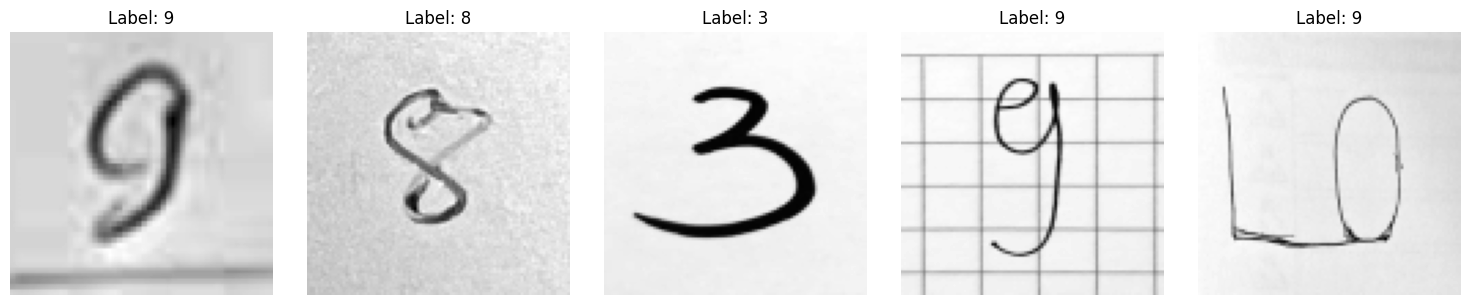

C:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1
Train loss: 1.0844
Test loss: 0.5471 - Accuracy: 84.78%
Epoch 2
Train loss: 0.4791
Test loss: 0.3467 - Accuracy: 90.13%
Epoch 3
Train loss: 0.3681
Test loss: 0.4437 - Accuracy: 87.68%
Epoch 4
Train loss: 0.3039
Test loss: 0.2985 - Accuracy: 91.17%
Epoch 5
Train loss: 0.2334
Test loss: 0.3958 - Accuracy: 88.64%
Epoch 6
Train loss: 0.2278
Test loss: 0.3036 - Accuracy: 92.35%
Epoch 7
Train loss: 0.1850
Test loss: 0.3905 - Accuracy: 88.86%
Epoch 8
Train loss: 0.1801
Test loss: 0.2344 - Accuracy: 94.28%
Epoch 9
Train loss: 0.1349
Test loss: 0.3458 - Accuracy: 92.58%
Epoch 10
Train loss: 0.1607
Test loss: 0.2595 - Accuracy: 93.24%
Epoch 11
Train loss: 0.1437
Test loss: 0.2549 - Accuracy: 92.50%
Epoch 12
Train loss: 0.1277
Test loss: 0.2459 - Accuracy: 94.06%
Epoch 13
Train loss: 0.1222
Test loss: 0.2183 - Accuracy: 93.54%
Epoch 14
Train loss: 0.1126
Test loss: 0.3544 - Accuracy: 91.17%
Epoch 15
Train loss: 0.1001
Test loss: 0.2800 - Accuracy: 93.10%
Epoch 16
Train loss: 0.1169
Test l

In [7]:
# Đường dẫn
root_dir = r"C:\Users\ADMIN\Desktop\ML\sort_images\sort_images"
INPUT_FOLDER = r"C:\Users\ADMIN\Desktop\ML\data.2025"
OUTPUT_CSV = r"C:\Users\ADMIN\Desktop\ML\sub_mobilenet.csv"

# Tải dữ liệu
x_data, y_data = load_image_paths_and_labels(root_dir)

# Chia tập
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=y_data, random_state=42)

# Tạo dataset và loader
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
#show ảnh 
import matplotlib.pyplot as plt

def show_first_n_images(dataset, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        img_tensor, label = dataset[i]  # Lấy ảnh và nhãn
        img_np = img_tensor.squeeze().numpy()  # Loại bỏ chiều kênh và chuyển về NumPy

        plt.subplot(1, n, i+1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Gọi hàm để hiển thị 5 ảnh đầu tiên
show_first_n_images(train_dataset, n=5)

# Tạo model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(device)

# Loss và optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện
for epoch in range(1, 21):
    print(f"Epoch {epoch}")
    train(model, train_loader, criterion, optimizer, device)
    test(model, test_loader, criterion, device)

# Dự đoán folder mới
predict_digits_from_folder(model, INPUT_FOLDER, OUTPUT_CSV, device)


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def evaluate_and_plot_confusion_matrix(model, dataloader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Độ chính xác tổng thể
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Accuracy on test set: {acc * 100:.2f}%")

    # Ma trận nhầm lẫn
    cm = confusion_matrix(all_labels, all_preds)

    # In chính xác từng lớp
    print("\n🎯 Accuracy per class:")
    for i in range(len(cm)):
        correct = cm[i][i]
        total = cm[i].sum()
        class_acc = correct / total if total > 0 else 0
        label_name = class_names[i] if class_names else str(i)
        print(f"  - {label_name}: {class_acc * 100:.2f}% ({correct}/{total})")

    # Vẽ ma trận nhầm lẫn
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix")
    plt.show()




✅ Accuracy on test set: 90.57%

🎯 Accuracy per class:
  - 0: 95.42% (125/131)
  - 1: 93.38% (127/136)
  - 2: 94.07% (127/135)
  - 3: 97.04% (131/135)
  - 4: 83.70% (113/135)
  - 5: 90.30% (121/134)
  - 6: 97.74% (130/133)
  - 7: 91.97% (126/137)
  - 8: 83.70% (113/135)
  - 9: 78.68% (107/136)


<Figure size 800x600 with 0 Axes>

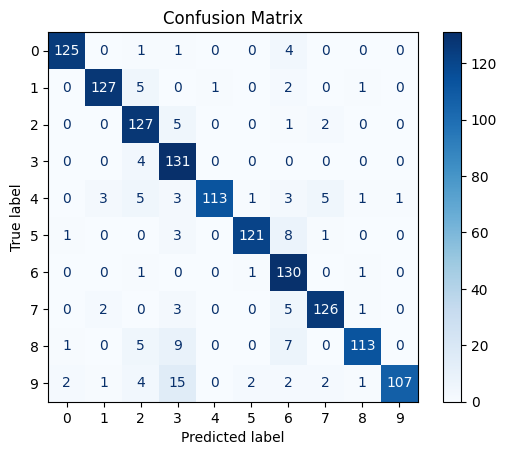

In [11]:
evaluate_and_plot_confusion_matrix(model, test_loader, device, class_names=[str(i) for i in range(10)])


In [ ]:
# dựa vào độ chính xác qua các epoch ta thấy độ chính xác của mô hình rôi vào khoảng 85% (tốt hơn cnn)
# các số có độ chính xác cao như là 0,3,6
# các số có độ chính xác thấp như là 7,4,8
# về ma trận nhầm lẫn thì hầu như đường chéo chính chiếm ưu thế so với các ô còn lại 
# Tuy các số dự đoán vãn còn xảy ra tình trạng nhầm lẫn nhau nhưng nhìn chung phần nhấm lẫn không quá 10 chữ số cho thấy mô hình đã có cải thiện hơn 
# rất nhiều so với cnn nhưng tỉ lệ chính xác giũa các lớp vẫn còn chênh lệch hơi nhiều lớp 9 (78%) , lớp 6 97,74%) 
# Bên cạnh đó việc xuất hiện thêm các ô số 0 trong ma trận nhầm lẫn cho thấy độ chính xác của bài toán đã được cải thiện rất nhiều 